In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from datetime import datetime

In [2]:
selected_columns = pd.read_csv('data/selected_columns.csv',  index_col=0)
numerical_columns = pd.read_csv('data/numerical_columns.csv', index_col=0)
categorical_columns = pd.read_csv('data/categorical_columns.csv', index_col=0)

In [3]:
# Asumsikan df_train_selected_columns
df_train_selected_columns = selected_columns

# # Pisahkan fitur dan target
X = df_train_selected_columns.drop(columns=["TARGET"])  
y = df_train_selected_columns["TARGET"]

### Model XGBoost

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing for numerical data: impute missing values with mean
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data: impute missing values with most frequent value (mode), then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='binary:logistic', eval_metric='auc', min_child_weight=10, max_depth=3, n_jobs=-1))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['REG_CITY_NOT_WORK_CITY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'AGE_YEARS',
                                                   'YEARS_EMPLOYED',
                                                   'YEARS_REGISTRATION',
                                                   'EXT_SOURCE_1',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'RATE_OF_LOAN']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImpute...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

### Evaluation Model

AUC: 0.7625178686305804
Precision: 0.28880233690360274
Recall: 0.2996564962618711


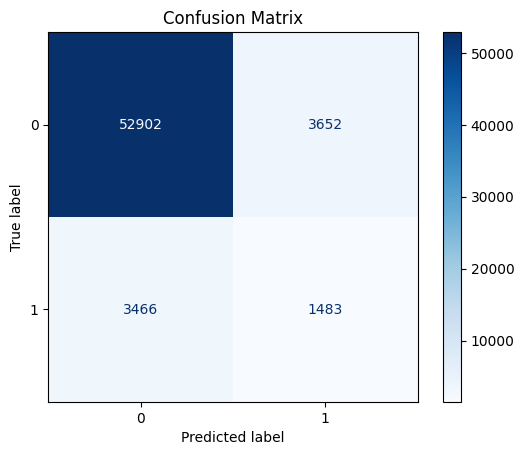

In [5]:
# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC: {auc}')
# Calculate precision and recall
threshold = 0.2
y_pred = (y_pred_prob >= threshold).astype(int)

precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro', 'micro', or 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='binary')        # Use 'macro', 'micro', or 'weighted' for multi-class

# Print precision and recall
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.named_steps['classifier'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Deployment Model

In [6]:
# function take user and its feature and output IF he is high risk or low risk 
def predict_new_user(model, feature_values):
    feature_values["RATE_OF_LOAN"]=feature_values["AMT_ANNUITY"]/feature_values["AMT_CREDIT"]
    
    feature_values["AMT_INCOME_TOTAL"]=np.log(feature_values["AMT_INCOME_TOTAL"])
    feature_values["AMT_CREDIT"]=np.log(feature_values["AMT_CREDIT"])
    feature_values["AMT_ANNUITY"]=np.log(feature_values["AMT_ANNUITY"])
    feature_values["AMT_GOODS_PRICE"]=np.log(feature_values["AMT_GOODS_PRICE"])
    
    # Ensure the feature values are provided in the correct order
    expected_features = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR','FLAG_OWN_REALTY',"NAME_INCOME_TYPE",
                    "REG_CITY_NOT_WORK_CITY",
                    'CNT_CHILDREN','AMT_INCOME_TOTAL', 'AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','AGE_YEARS',
                    'YEARS_EMPLOYED','YEARS_REGISTRATION',
                    'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',"RATE_OF_LOAN"]
    # Create a DataFrame for the single instance
    input_df = pd.DataFrame([feature_values], columns=expected_features)
    
    # Predict using the model
    pred_prob = model.predict_proba(input_df)[0]
    print("Probabilty of Not Rapaying ",pred_prob[1])
    # Determine risk category based on the predicted probability
    risk_category = "Low Risk" if pred_prob[-1] < 0.2 else "High Risk"
    return risk_category

### Testing Prediction

In [7]:
features_pred = {
    'CODE_GENDER': "M", 
    'NAME_EDUCATION_TYPE': "Higher education", 
    'FLAG_OWN_CAR': 1, 
    'FLAG_OWN_REALTY': 1, 
    'NAME_INCOME_TYPE': "Working",
    'REG_CITY_NOT_WORK_CITY': 0, 
    'CNT_CHILDREN': 2, 
    'AMT_INCOME_TOTAL': 1200, 
    'AMT_CREDIT': 3000, 
    'AMT_ANNUITY': 20243,
    'AMT_GOODS_PRICE': 98798, 
    'AGE_YEARS': 60, 
    'YEARS_EMPLOYED': 20, 
    'YEARS_REGISTRATION': 2,
    'EXT_SOURCE_1': 0.6, 
    'EXT_SOURCE_2': 0.3, 
    'EXT_SOURCE_3': 0.2
}

risk_status = predict_new_user(model, features_pred)
print("Risk Status:", risk_status)

Probabilty of Not Rapaying  0.099277236
Risk Status: Low Risk


### Save Model

In [8]:
import pickle
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)